In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import cas as cas
import importlib
import pickle

## DQA

In [2]:
i_c = 230; c_shunt = 50; c_z = 4.4; lq = 480; alpha = 0.4; d = 0.0
qubit0 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d, 5, 10, 10)
qubit1 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d, 5, 10, 10)

i_sigma = 565; c_sigma = 11; lc = 580; d = 0.0
coupler01 = cas.Coupler(i_sigma, c_sigma, lc, d)

elements = [qubit0, coupler01, qubit1]

# couple qubits in a chain
m = 65; m_mat = np.zeros((3, 3));
m_mat[0, 1] = m; m_mat[1, 2] = -m;
m_mat = -(m_mat + m_mat.T)

trunc_vec = np.array([7, 4, 7])

circuit = cas.AnnealingCircuit(elements, m_mat, trunc_vec)

In [8]:
schedule_dict = {}; pts = 41;
s = np.linspace(0, 1, pts)
schedule_dict["points"] = pts

s1 = 0.1; # location of first minimum gap
Delta_1 = 0.05*2*np.pi; # size of the first minimum gap
hx1 = 0.5*2*np.pi; hx2 = 1*2*np.pi;
hz1 = 0.5*2*np.pi; hz2 = 0.8*2*np.pi;
J = 0.7*2*np.pi

schedule_dict["x_0"] = hx1*np.array([(Delta_1/2/hx1 - 1)*(s/s1) + 1 if s<=s1 else (Delta_1/2/hx1)*((s-1)/(s1-1)) for s in s])
schedule_dict["z_0"] = hz1*np.array([0 if s<=s1 else (s-s1)/(1-s1) for s in s])

schedule_dict["x_1"] = hx2*np.array([1 if s<=s1 else ((s-1)/(s1-1)) for s in s])
schedule_dict["z_1"] = hz2*np.array([0 if s<=s1 else (s-s1)/(1-s1) for s in s])

schedule_dict["zz_0,1"] = J*np.array([0 if s<=s1 else (s-s1)/(1-s1) for s in s])

In [5]:
%%time

custom_flux_dict_num = circuit.get_custom_fluxes_num(schedule_dict, verbose=True, optimizer_method="leastsq")

point #6 residual norm: chedule point 6 / 41
 0.026516485323455345  (GHz) 



/home/mostafa/Dropbox/Research/FluQS/codes/quack/quack/schedule/multi_qubit.py:917: UserWarning: For the point #6, solver found solutions that are not optimal. The relative error is 2.73 %
  ).format(p+1, rel_error * 100)


point #7 residual norm: 
 0.04442853606553931  (GHz) 



/home/mostafa/Dropbox/Research/FluQS/codes/quack/quack/schedule/multi_qubit.py:917: UserWarning: For the point #7, solver found solutions that are not optimal. The relative error is 4.69 %
  ).format(p+1, rel_error * 100)


point #8 residual norm: 
 0.06668429677970567  (GHz) 



/home/mostafa/Dropbox/Research/FluQS/codes/quack/quack/schedule/multi_qubit.py:917: UserWarning: For the point #8, solver found solutions that are not optimal. The relative error is 7.23 %
  ).format(p+1, rel_error * 100)


point #41 residual norm: hedule point 41 / 41
 0.023326578188217463  (GHz) 

CPU times: user 4h 36min 10s, sys: 4h 29min 51s, total: 9h 6min 2s
Wall time: 1h 18min 45s


/home/mostafa/Dropbox/Research/FluQS/codes/quack/quack/schedule/multi_qubit.py:917: UserWarning: For the point #41, solver found solutions that are not optimal. The relative error is 1.99 %
  ).format(p+1, rel_error * 100)


In [6]:
%%time

custom_flux_dict_pwsw = circuit.get_custom_fluxes_pwsw(schedule_dict, verbose=True, optimizer_method="leastsq")

calculating qubit biases for qubit 1 of 2
point #40 single qubit residuals: 
 [-9.25983399e-02  2.52731402e-05] 

calculating qubit biases for qubit 2 of 2


/home/mostafa/Dropbox/Research/FluQS/codes/quack/quack/schedule/one_qubit.py:680: UserWarning: For the point #40, solver found solutions that are not optimal. The relative error is 2.95 % for single qubit residuals
  ).format(i, rel_error * 100)


point #40 single qubit residuals: 
 [-9.34679451e-02  5.73553260e-05] 


 calculating coupler bias for coupler 1 of 1


/home/mostafa/Dropbox/Research/FluQS/codes/quack/quack/schedule/one_qubit.py:680: UserWarning: For the point #40, solver found solutions that are not optimal. The relative error is 1.86 % for single qubit residuals
  ).format(i, rel_error * 100)


CPU times: user 37min 45s, sys: 37min 50s, total: 1h 15min 36s
Wall time: 8min 27s


In [24]:
with open('./data/circuit_DQA.pkl', 'wb') as file:
    pickle.dump(circuit, file)

In [4]:
with open('./data/circuit_DQA.pkl', 'rb') as file:
    circuit = pickle.load(file)
custom_flux_dict_num = circuit.custom_flux_num
custom_flux_dict_pwsw = circuit.custom_flux_pwsw

In [5]:
%%time

ising_sw_from_num = circuit.get_ising_sw(custom_flux_dict_num, verbose=True)
ising_sw_from_pwsw = circuit.get_ising_sw(custom_flux_dict_pwsw, verbose=True)

CPU times: user 7min 30s, sys: 7min 21s, total: 14min 52s
Wall time: 2min 7s


In [6]:
%%time
e_circuit = circuit.calculate_spectrum(custom_flux_dict_num, levels=6)

CPU times: user 1min 8s, sys: 1min 10s, total: 2min 19s
Wall time: 11.7 s


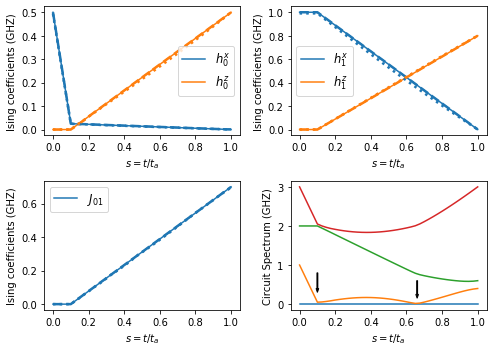

In [10]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((7, 5))

for i in range(2):
    ax1 = plt.subplot(2, 2, i+1)
    
    plt.plot(s, schedule_dict["x_"+str(i)]/2/np.pi, label=r"$h^x_{0:d}$".format(i), color="C0")
    plt.plot(s, schedule_dict["z_"+str(i)]/2/np.pi, label=r"$h^z_{0:d}$".format(i), color="C1")

    plt.plot(s, ising_sw_from_num["x_"+str(i)]/2/np.pi, color="C0", ls='--', lw=2.5 )
    plt.plot(s, ising_sw_from_num["z_"+str(i)]/2/np.pi, color="C1", ls='--', lw=2.5 )
    
    plt.plot(s, ising_sw_from_pwsw["x_"+str(i)]/2/np.pi, color="C0", ls=':', lw=2.5 )
    plt.plot(s, ising_sw_from_pwsw["z_"+str(i)]/2/np.pi, color="C1", ls=':', lw=2.5 )
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend(fontsize=11.5)
    
for i in range(1):
    ax2 = plt.subplot(2, 2, i+3)
    
    plt.plot(s, schedule_dict["zz_"+str(i)+','+str(i+1)]/2/np.pi, label=r"$J_{{{0:d}{1:d}}}$".format(i, i+1))
    
    plt.plot(s, ising_sw_from_num["zz_"+str(i)+','+str(i+1)]/2/np.pi, color="C0", ls='--', lw=2.5 )
    
    plt.plot(s, ising_sw_from_pwsw["zz_"+str(i)+','+str(i+1)]/2/np.pi, color="C0", ls=':', lw=2.5 )
    
#     plt.ylim(-0.85, -0.75)
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend(fontsize=11.5)
    
ax3 = plt.subplot(2, 2, 4)
plt.plot(s, e_circuit[:, 0:4]/2/np.pi)
plt.arrow(0.1, 0.8, 0, -0.4, width=0.005, ec='black', fc='black', head_length=0.1)
plt.arrow(0.66, 0.6, 0, -0.35, width=0.005, ec='black', fc='black', head_length=0.1)
plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Circuit Spectrum (GHZ)")
    
plt.tight_layout()
# plt.savefig("./plots/DQA_schedules.pdf", bbox_inches="tight")
plt.show()

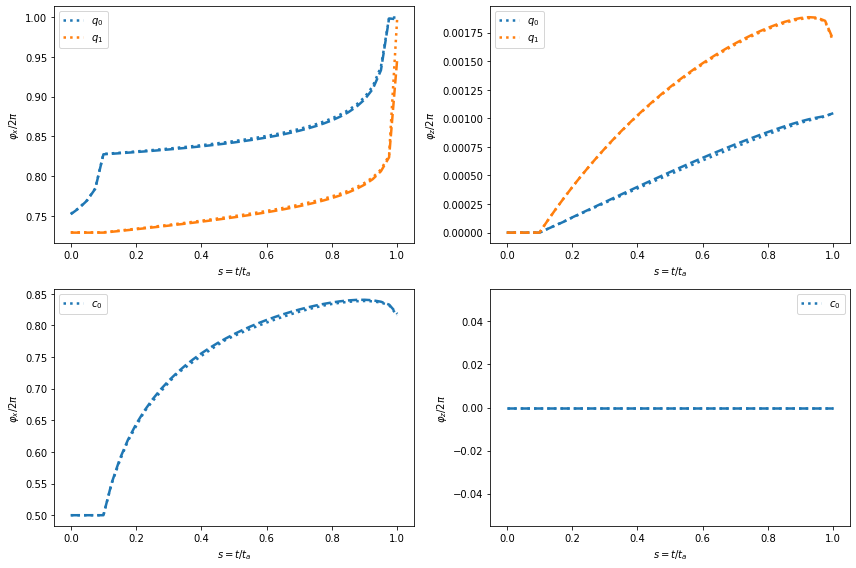

In [25]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((12, 8))

ax1 = plt.subplot(2, 2, 1)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(qubit_index)]/2/np.pi, ':', color="C{0:d}".format(i), lw=2.5, label=r"$q_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_num["phix_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()

ax2 = plt.subplot(2, 2, 2)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(qubit_index)]/2/np.pi, ':', color="C{0:d}".format(i), lw=2.5, label=r"$q_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_num["phiz_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
ax3 = plt.subplot(2, 2, 3)
# plt.hlines(1, 0, 1, alpha=0.3)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(coupler_index)]/2/np.pi, ':', color="C{0:d}".format(i), lw=2.5, label=r"$c_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_num["phix_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()
    
ax4 = plt.subplot(2, 2, 4)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(coupler_index)]/2/np.pi, ':', color="C{0:d}".format(i), lw=2.5, label=r"$c_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_num["phiz_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
    
plt.tight_layout()
# plt.savefig("./plots/fluxes.pdf", bbox_inches="tight")
plt.show()